## Anomaly Detection- windowed method 

In [1]:
import numpy as np
import pickle
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.layers import Lambda, Input, Dense, Dropout
from utils.functions import sample, create_sequences, get_error_term
from model.vae_window import vae_window

Importing the dataset

In [2]:
data = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv",
                   parse_dates=True, index_col="timestamp")

In [3]:
with open('lists.pkl', 'rb') as f:
    lists = pickle.load(f)

# Access the lists
instances_of_anomaly= lists[0]

In [4]:
data_with_anomaly = data.copy()
data_with_anomaly['anomaly'] = 0
for instance in instances_of_anomaly: 
    start = pd.to_datetime(instance[0])
    end = pd.to_datetime(instance[1])
    data_with_anomaly.loc[(data_with_anomaly.index >= start) & (data_with_anomaly.index <= end), 'anomaly'] = 1

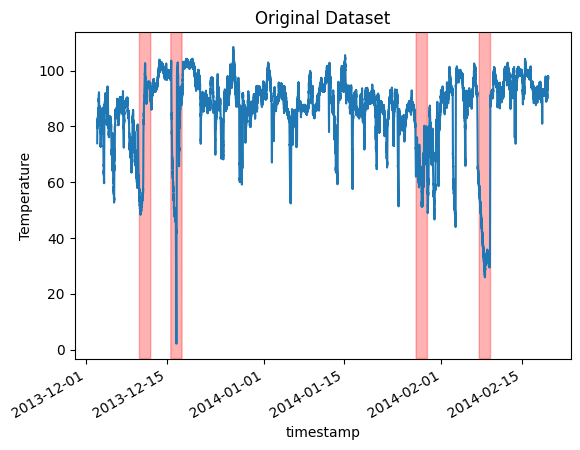

In [5]:
fig, ax = plt.subplots()
data.plot(legend=False, ax=ax)
ax.fill_between(data_with_anomaly.index, 0, 1, where=data_with_anomaly['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Real anomaly')
plt.ylabel("Temperature")
plt.title("Original Dataset")
plt.show()

Splitting training and testing

In [6]:
# Splitting to train and test
test_ratio =0.3
start = int(len(data) * 0.25 )  # or 0 
tr_data = data.iloc[start: int(len(data) * (1 - test_ratio))]
tst_data1 = data.iloc[int(len(data) * (1 - test_ratio)) :]
tst_data2 = data.iloc[0:start]

In [7]:
tr_data

,value
timestamp,
2013-12-22 14:00:00,87.168898
2013-12-22 14:05:00,87.933798
2013-12-22 14:10:00,85.804768
2013-12-22 14:15:00,85.955663
2013-12-22 14:20:00,86.815269
...,...
2014-01-26 23:40:00,88.470506
2014-01-26 23:45:00,88.395883
2014-01-26 23:50:00,88.608302


Normailzing the training set 

In [8]:
# Normalize and save the mean and std we get, for normalizing test data.
training_mean = tr_data.mean()
training_std = tr_data.std()
train_scaled = (tr_data - training_mean) / training_std
print("Number of training samples:", len(train_scaled))

Number of training samples: 10213


Function to create the windowed data

In [9]:
step_size = 288

train = create_sequences(train_scaled.values, step_size)
print("Training input shape: ", train.shape)

Training input shape:  (9926, 288, 1)


VAE model

In [10]:
vae = vae_window(train, latent_dim=8)

In [11]:
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 288, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 144, 32)   │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 144, 32)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 72, 16)    │      3,600 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 8),       │     22,304 │ input_layer[0][0] │
│ (Functional)        │ (None, 8), (None, │            │                   │
│                     │ 8)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1152)      │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 288, 1)    │     59,553 │ encoder[0][2]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │      9,224 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │      9,224 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer      │ (None, 288, 1)    │          0 │ input_layer[0][0… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 81,857 (319.75 KB)

 Trainable params: 81,857 (319.75 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = vae.fit(
    train,
    train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 29765.4082 - val_loss: 9350.5996
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6959.0566 - val_loss: 3304.4099
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3637.7153 - val_loss: 2600.7263
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2923.0405 - val_loss: 2210.1042
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2429.3152 - val_loss: 2059.2512
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2208.9604 - val_loss: 2038.6740
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2093.4919 - val_loss: 2127.8906
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1926.0737 - val_loss: 2076.5564
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1835.3687 - val_loss: 2114.3411
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1719.4816 - val_loss: 2236.1028
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1681.2041 - val_loss: 2263.2

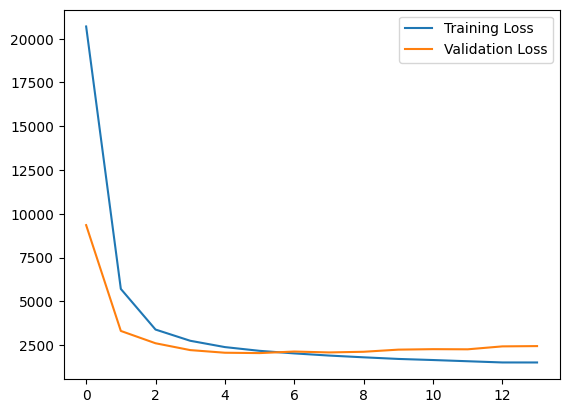

In [13]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(9926, 1)


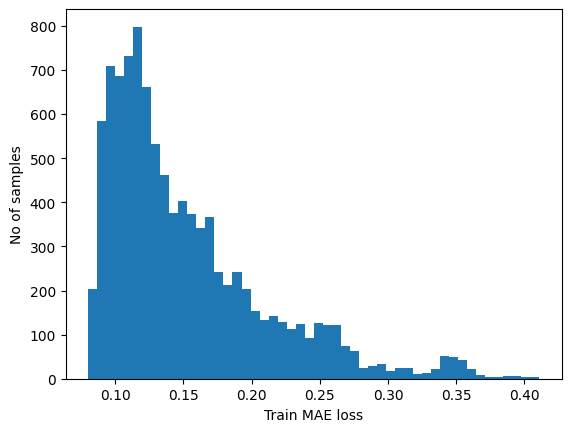

Reconstruction error threshold:  0.4108060309324718


In [14]:
# Get train MAE loss.
train_pred = vae.predict(train)[0]
train_mae_loss = np.mean(np.abs(train_pred - train), axis=1)
print(train_mae_loss.shape)
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [15]:
print(train_pred.shape)

(9926, 288, 1)


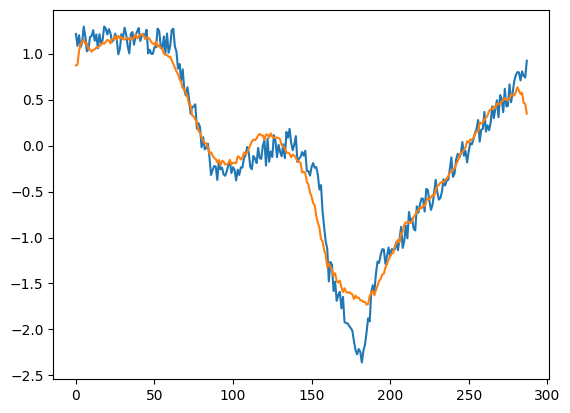

In [16]:
# Checking how the first sequence is learnt
plt.plot(train[90])
plt.plot(train_pred[90])
plt.show()

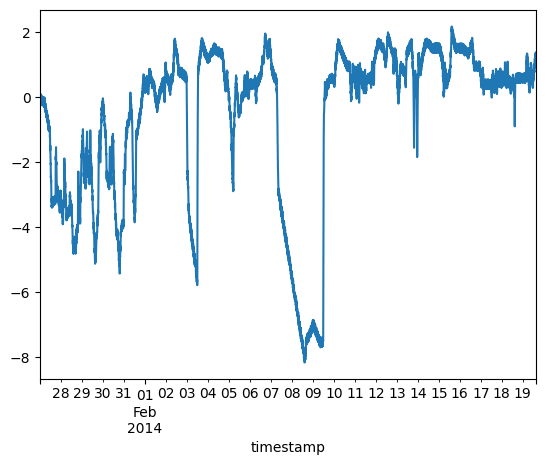

Test input shape:  (6522, 288, 1)
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(6522, 1)


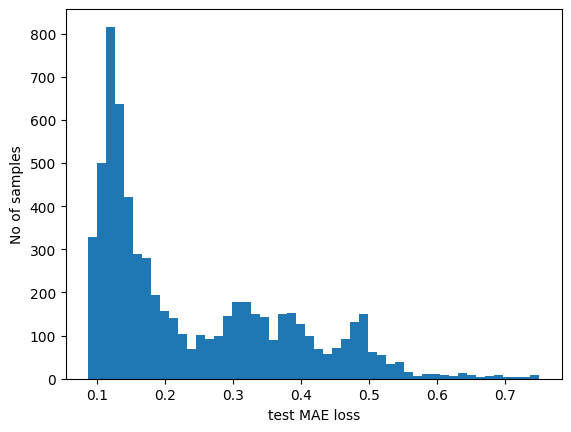

Number of anomaly samples:  942
Indices of anomaly samples:  (array([ 126,  128,  162,  163,  164,  165,  166,  167,  168,  169,  170,
        171,  172,  173,  174,  175,  176,  210,  211,  212,  213,  214,
        215,  216,  401,  402,  403,  404,  405,  454,  455,  456,  457,
        458,  459,  460,  461,  462,  463,  464,  465,  466,  467,  468,
        469,  470,  471,  472,  473,  474,  475,  476,  477,  478,  479,
        480,  481,  482,  483,  484,  485,  486,  487,  488,  489,  490,
        491,  492,  493,  494,  495,  496,  497,  498,  499,  500,  501,
        502,  503,  504,  505,  506,  507,  508,  509,  510,  511,  512,
        513,  514,  515,  516,  517,  518,  519,  520,  521,  522,  523,
        524,  525,  526,  527,  528,  600,  601,  602,  603,  604,  605,
        606,  607,  608,  609,  610,  611,  612,  613,  614,  615,  777,
        778,  779,  781,  782,  783,  784,  785,  786,  787,  788,  789,
        790,  791,  792,  793,  794,  800,  801,  802,  803,  

In [17]:

tst_data= tst_data1          #1 or 2
test_scaled = (tst_data - training_mean) / training_std
fig, ax = plt.subplots()
test_scaled.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
test = create_sequences(test_scaled.values, step_size)
print("Test input shape: ", test.shape)

# Get test MAE loss.
test_pred = vae.predict(test)[0]
test_mae_loss = np.mean(np.abs(test_pred - test), axis=1)
print(test_mae_loss.shape)
#test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [18]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
step_size = 288
anomalous_data_indices = []
for data_idx in range(step_size - 1, len(test_scaled) - step_size + 1):
    if np.all(anomalies[data_idx - step_size + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [19]:
# data i is an anomaly if more than 90% of samples [(i - timesteps + 1) to (i)] are anomalies
step_size = 288
anomalous_data_indices = []
for data_idx in range(step_size - 1, len(test_scaled) - step_size + 1):
    if np.sum(anomalies[data_idx - step_size + 1 : data_idx]) > step_size * 0.9:
        anomalous_data_indices.append(data_idx)

In [20]:
print("Indices of anomalies: ", anomalous_data_indices)

Indices of anomalies:  [3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641

In [21]:
df_subset = tst_data.iloc[anomalous_data_indices]
df_subset

,value
timestamp,
2014-02-08 02:00:00,42.018890
2014-02-08 02:05:00,43.376736
2014-02-08 02:10:00,42.931363
2014-02-08 02:15:00,43.117958
2014-02-08 02:20:00,43.773901
...,...
2014-02-09 08:35:00,30.021443
2014-02-09 08:40:00,29.426162
2014-02-09 08:45:00,30.445568


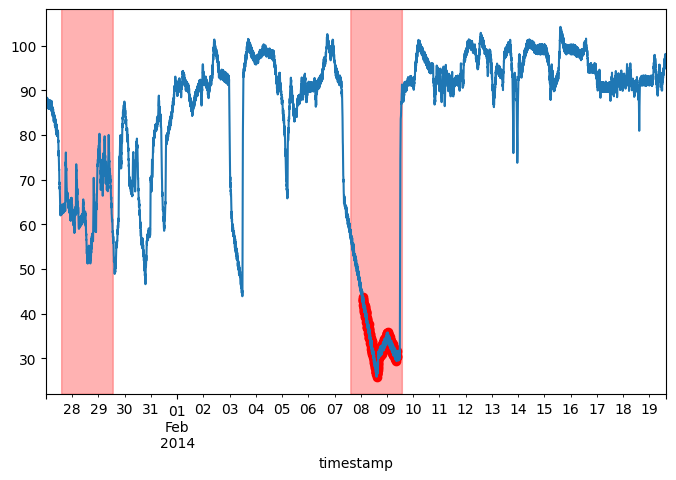

In [23]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
tst_data.plot(legend=False, ax=ax)
ax.fill_between(data_with_anomaly.index, 0, 1, where=data_with_anomaly['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Real anomaly')
ax.scatter(df_subset.index, df_subset['value'], color="r")
plt.show()